# **1. Importing Libraries**

In [40]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import json
tf.version


<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>

# **2. Procesing Data**

In [41]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-04-09 16:20:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2021-04-09 16:20:01 (158 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



###### **Loading and spliting Data**

In [42]:
df = pd.read_json('/tmp/sarcasm.json')
df.columns

Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')

In [43]:
len(df)

26709

In [44]:
label = df['is_sarcastic']
sentences = df['headline']
X_train, X_test, y_train, y_test = train_test_split(sentences, label, test_size=0.2)

###### **Tokenizing Data**

In [45]:

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(word_index)


{'<OOV>': 1, 'to': 2, 'of': 3, 'the': 4, 'in': 5, 'for': 6, 'a': 7, 'on': 8, 'and': 9, 'with': 10, 'is': 11, 'new': 12, 'trump': 13, 'man': 14, 'from': 15, 'at': 16, 'about': 17, 'you': 18, 'by': 19, 'this': 20, 'be': 21, 'out': 22, 'after': 23, 'up': 24, 'how': 25, 'as': 26, 'that': 27, 'it': 28, 'not': 29, 'are': 30, 'your': 31, 'his': 32, 'what': 33, 'he': 34, 'just': 35, 'who': 36, 'has': 37, 'all': 38, 'will': 39, 'more': 40, 'year': 41, 'one': 42, 'report': 43, 'why': 44, 'into': 45, 'area': 46, 'over': 47, 'u': 48, 'have': 49, 'donald': 50, 's': 51, 'day': 52, 'says': 53, 'can': 54, 'woman': 55, 'first': 56, 'like': 57, 'time': 58, "trump's": 59, 'old': 60, 'her': 61, 'no': 62, 'get': 63, 'off': 64, 'an': 65, 'people': 66, 'obama': 67, 'now': 68, 'life': 69, 'house': 70, 'make': 71, "'": 72, 'than': 73, 'still': 74, 'back': 75, 'was': 76, 'i': 77, 'my': 78, 'women': 79, 'white': 80, 'clinton': 81, 'down': 82, '5': 83, 'when': 84, 'if': 85, 'world': 86, 'before': 87, 'could': 88,

###### **Sequencing Data**

In [46]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=100, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=100, padding='post', truncating='post')


###### **Slicing Data into Test and Training Test**

In [47]:

def data_batch(X_train, y_train, X_test, y_test):
  train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(1000).batch(32)
  test_ds = tf.data.Dataset.from_tensor_slices(
      (X_test, y_test)).shuffle(1000).batch(32)
  return train_ds, test_ds
train_ds,test_ds = data_batch(X_train, y_train, X_test, y_test)


# **3. Creating Neural Network**

In [48]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.e = Embedding(10000, 16, input_length= 100)
    self.gM = GlobalMaxPooling1D()
    self.gA = GlobalAveragePooling1D()
    self.d1 = Dense(32, activation='relu')
    self.d2 = Dense(16, activation='relu')
    self.d3 = Dense(1, activation='sigmoid')
    self.dr = Dropout(0.3)
  def call(self, x):
    x = self.e(x)
    #x = self.gM(x)
    x = self.gA(x)
    x = self.d1(x)
    #x = self.d2(x)
    #x = self.dr(x)
    return self.d3(x)
  

In [49]:
model = MyModel()

###### **Optimizer and Loss Function**

In [50]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
Optimiser = tf.keras.optimizers.Adam()

######  **Metrics For Loss And Accuracy**

In [51]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

# **4. Function for training and Testing**

###### **Function For Training**

In [52]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    prediction = model(images, training=True)
    loss = loss_object(labels,prediction)
  gradient = tape.gradient(loss, model.trainable_variables)
  Optimiser.apply_gradients(zip(gradient, model.trainable_variables))
  train_loss(loss)
  train_accuracy(labels, prediction)

###### **Function For Testing**

In [53]:
@tf.function
def test_step(images, labels):
  prediction = model(images, training = False)
  t_loss = loss_object(labels, prediction)
  test_loss(t_loss)
  test_accuracy(labels, prediction)

# **5. Training Model** 

In [54]:
EPOCHS = 15
Train_LOSS = []
TRain_Accuracy = []
Test_LOSS = []
Test_Accuracy = []

for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  print(f'Epoch : {epoch+1}')

  desc = "EPOCHS {:0>4d}".format(epoch+1)

  for images, labels in tqdm(train_ds, desc=desc ):    
    train_step(images, labels)
      
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)
    
  

  print(
      f'Loss: {train_loss.result()}, '
      f'Accuracy: {train_accuracy.result()*100}, '
      f'Test Loss: {test_loss.result()}, '
      f'Test Accuracy: {test_accuracy.result()*100}'
  )

  Train_LOSS.append(train_loss.result())
  TRain_Accuracy.append(train_accuracy.result()*100)
  Test_LOSS.append(test_loss.result())
  Test_Accuracy.append(test_accuracy.result()*100)

  if epoch==0:
    min_Loss = test_loss.result()
    min_Accuracy = test_accuracy.result()*100
  elif (min_Loss>test_loss.result()):
    if (min_Accuracy <= test_accuracy.result()*100) :
      min_Loss = test_loss.result()
      min_Accuracy = ( test_accuracy.result()*100)
      print(f"Saving Best Model {epoch+1}")
      path = f'/content/BestModel.h5'  
  

      model.save_weights(path)                            

Epoch : 1



Loss: 0.643668532371521, Accuracy: 62.674312591552734, Test Loss: 0.5115951299667358, Test Accuracy: 78.43563079833984
Epoch : 2



Loss: 0.3841143846511841, Accuracy: 84.37520599365234, Test Loss: 0.36063867807388306, Test Accuracy: 84.07061004638672
Saving Best Model 2
Epoch : 3



Loss: 0.292815625667572, Accuracy: 88.35528564453125, Test Loss: 0.33276650309562683, Test Accuracy: 85.70109558105469
Saving Best Model 3
Epoch : 4



Loss: 0.24705848097801208, Accuracy: 90.37705993652344, Test Loss: 0.3327412009239197, Test Accuracy: 85.60753631591797
Epoch : 5



Loss: 0.212692990899086, Accuracy: 91.90782165527344, Test Loss: 0.3279319703578949, Test Accuracy: 86.01795959472656
Saving Best Model 5
Epoch : 6



Loss: 0.18811006844043732, Accuracy: 92.92765808105469, Test Loss: 0.33830803632736206, Test Accuracy: 85.85079956054688
Epoch : 7



Loss: 0.1671179085969925, Accuracy: 93.95584106445312, Test Loss: 0.3516162931919098, Test Accuracy: 85.80838775634766
Epoch : 8



Loss: 0.14972633123397827, Accuracy: 94.55931854248047, Test Loss: 0.3860347867012024, Test Accuracy: 84.4648208618164
Epoch : 9



Loss: 0.13717208802700043, Accuracy: 94.92990112304688, Test Loss: 0.41422227025032043, Test Accuracy: 84.12549591064453
Epoch : 10



Loss: 0.12431871891021729, Accuracy: 95.6165771484375, Test Loss: 0.43007075786590576, Test Accuracy: 84.21781921386719
Epoch : 11



Loss: 0.11290738731622696, Accuracy: 96.07321166992188, Test Loss: 0.4372016191482544, Test Accuracy: 84.81786346435547
Epoch : 12



Loss: 0.10327079892158508, Accuracy: 96.37444305419922, Test Loss: 0.4753957986831665, Test Accuracy: 83.96956634521484
Epoch : 13



Loss: 0.09549304842948914, Accuracy: 96.61119842529297, Test Loss: 0.512302815914154, Test Accuracy: 83.61776733398438
Epoch : 14



Loss: 0.08712664991617203, Accuracy: 97.09019470214844, Test Loss: 0.5232535004615784, Test Accuracy: 84.16416931152344
Epoch : 15



Loss: 0.08037380874156952, Accuracy: 97.27549743652344, Test Loss: 0.5567829608917236, Test Accuracy: 83.95957946777344


### **6. Ploting**

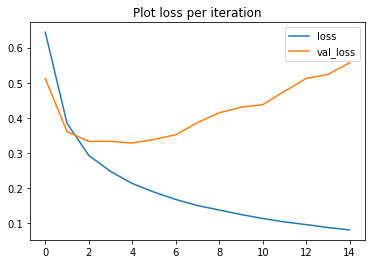

In [55]:
# Plot loss per iteration
plt.plot(Train_LOSS, label='loss')
plt.plot(Test_LOSS, label='val_loss')
plt.title('Plot loss per iteration')
plt.legend()

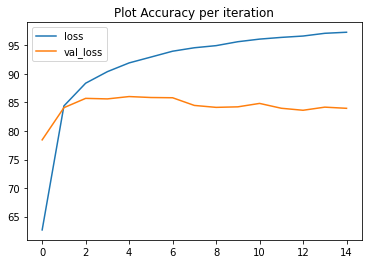

In [56]:
# Plot Accuracy per iteration
plt.plot(TRain_Accuracy, label='loss')
plt.plot(Test_Accuracy, label='val_loss')
plt.title('Plot Accuracy per iteration')
plt.legend()

## **7. Validating**

In [57]:
new_sentence = ['''Wisconsin Woman Takes Husband to Police for "Talking Stupidly"''',
                'Warehouse Worker Packing Stress Balls Punched His Boss in Face', 
                'Organisers of secret Paris dinner parties say ministers did not attend']

In [58]:
new_sentence = tokenizer.texts_to_sequences(new_sentence)
new_sentence = pad_sequences(new_sentence, maxlen=100, padding='post', truncating='post')

In [59]:
prediction = model(new_sentence)
print(prediction)

tf.Tensor(
[[0.9570823 ]
 [0.9504098 ]
 [0.03828943]], shape=(3, 1), dtype=float32)
